In [1]:
!rm -rf ./tmp

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mmcv
from mmengine.visualization import Visualizer
from pprint import pprint
import pandas as pd
from mmpose.apis import MMPoseInferencer
from modules.utils.visualization import generate_connection_line, joint_colors
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear


## DEFINE MODELS
### Faster RCNN for Human Detection
mmdet_config_path = './modules/human_detector/config/faster_rcnn.py'
mmdet_model_weight = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/'\
        'faster_rcnn_r50_fpn_1x_coco-person/faster_rcnn_r50_fpn_1x_coco-person_20201216_175929-d022e227.pth'

### HR-Net for 2D Pose Estimation
mmpose_config_path = './modules/pose_estimator_2d/config/hrnet.py'
mmpose_model_weight = 'https://download.openmmlab.com/mmpose/v1/'\
        'body_2d_keypoint/topdown_heatmap/coco/'\
            'td-hm_hrnet-w48_udp-8xb32-210e_coco-384x288-70d7ab01_20220913.pth'
mmpose_inferencer = MMPoseInferencer(
    pose2d=mmpose_config_path,
    pose2d_weights=mmpose_model_weight,
    det_model=mmdet_config_path,
    det_weights=mmdet_model_weight,
    det_cat_ids=[0]
)

# 2D-3D Lifter
mlp_lifter = LitSimpleBaselineLinear(exclude_ankle=True, exclude_hip=True)
pretrained_model_path = './saved_lifter_2d_3d_model/drive_and_act/transfer_learning/synthetic_cabin_ir/full/linear_model_all_actor'
with open(f'{pretrained_model_path}/best_model_path.txt', 'r') as f:
    checkpoint_path = f.readline()
mlp_lifter.load_from_checkpoint(checkpoint_path)
mlp_lifter.eval()
## INFERENCE
video_file = '/root/data/raw/alplab/center.mp4'
# video_file = '/root/data/raw/alplab/right.mp4'

cap = cv2.VideoCapture(video_file)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# print(f'total_frames = {total_frames}')
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
sampling_rate = int(0.5 * np.floor(frame_rate))

print(total_frames)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w48_udp-8xb32-210e_coco-384x288-70d7ab01_20220913.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

01/09 23:27:32 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
01/09 23:27:32 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco-person/faster_rcnn_r50_fpn_1x_coco-person_20201216_175929-d022e227.pth
01/

Output()

[[ 3.9204075   0.4590121   2.771996  ]
 [-0.47248542 -0.74916905  4.1295137 ]
 [ 2.5998244   2.45295    -4.1592607 ]
 [-0.10274267  4.7089868  -4.3209095 ]
 [ 3.9488313   0.05462694 -0.8510585 ]
 [-4.253503    0.20272517  5.960885  ]
 [ 3.2734542  -4.467369    4.8016768 ]
 [-4.1323113   2.7624938  -0.08392787]
 [-0.17242289  1.4580228   0.72500014]
 [ 2.4588385  -2.4203334   0.7658889 ]
 [-1.8282309   4.7215495   5.0315776 ]
 [ 1.295593    0.44669986  2.5129359 ]
 [-1.4738768   3.8115685   7.5852027 ]]


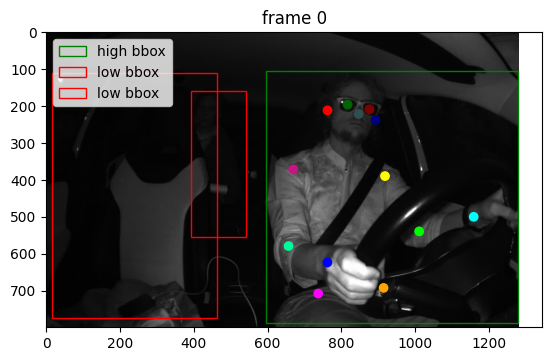

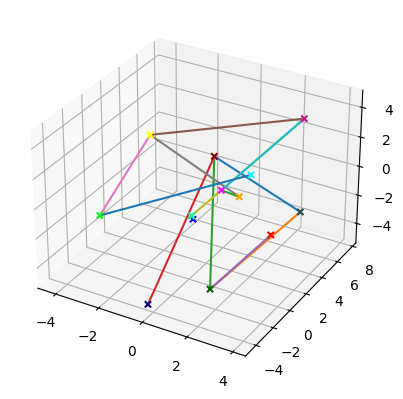

In [6]:
images = []
num_keypoints = 13
# frame_numbers = [0, 1000, 5000]
frame_numbers = [0]
for frame_number in frame_numbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    _, image = cap.read()
    images.append(image)

## Model Inference
mmpose_results = mmpose_inferencer(images)
for idx, mmpose_result in enumerate(mmpose_results):
    image_results = mmpose_result['predictions'][0]
    fig, ax = plt.subplots()
    ax.imshow(images[idx])
    ax.set_title(f'frame {frame_numbers[idx]}')
    # find the best box
    best_box_idx = np.argmax([box['bbox_score'] for box in image_results])
    for idx, detected in enumerate(image_results):
        ## bounding box in top-left / bottom-right format
        bbox = detected['bbox']
        x = bbox[0][0]
        y = bbox[0][1]
        w = bbox[0][2] - bbox[0][0]
        h = bbox[0][3] - bbox[0][1]
        if idx != best_box_idx:
            # draw lower match bbox as red
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', label='low bbox')
        else:
            # draw highest match bbox as green
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none', label='high bbox')
            # plot 2D keypoints
            pose_2d = np.array(detected['keypoints'])
            ax.scatter(pose_2d[:num_keypoints, 0], pose_2d[:num_keypoints, 1], c=joint_colors[:num_keypoints])
            image_height, image_width, _ = image.shape
            pose_2d[:, 0] = pose_2d[:, 0] / image_height
            pose_2d[:, 1] = pose_2d[:, 1] / image_width
            pose_3d = mlp_lifter(torch.tensor(pose_2d[:num_keypoints]).flatten().unsqueeze(0).float())
            pose_3d_np = pose_3d.cpu().detach().numpy()[0].reshape(-1, 3)
            print(pose_3d_np)
            connections = generate_connection_line(pose_3d_np)
            x = pose_3d_np[:, 0]
            y = pose_3d_np[:, 1]
            z = pose_3d_np[:, 2]
            fig_3d = plt.figure()
            ax_3d = fig_3d.add_subplot(1, 1, 1, projection='3d')
            predict_plot = ax_3d.scatter3D(x, z, -y, c=joint_colors[:num_keypoints], marker='x', depthshade=False, label='Predict')

            for i in range(len(connections) // 2):
                ax_3d.plot3D(
                    [connections[2*i]['x'], connections[2*i + 1]['x']],
                    [connections[2*i]['z'], connections[2*i + 1]['z']],
                    [-connections[2*i]['y'], -connections[2*i + 1]['y']],
                )
        ax.add_patch(rect)
    ax.legend(loc='upper left')